In [49]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [50]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [51]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [52]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [53]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [54]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [55]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Station = Base.classes.station
Measurement = Base.classes.measurement

In [56]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [57]:
from sqlalchemy import create_engine, text, inspect, func

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])
    
print()

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [58]:
engine.execute(text('SELECT * FROM measurement LIMIT 5')).fetchall()

[(0, 'USC00519397', '2010-01-01', 2.0, 18.3),
 (1, 'USC00519397', '2010-01-02', 0.0, 17.2),
 (2, 'USC00519397', '2010-01-03', 0.0, 23.3),
 (3, 'USC00519397', '2010-01-04', 0.0, 24.4),
 (4, 'USC00519397', '2010-01-06', None, 22.8)]

In [161]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date[0]


'2017-08-23'

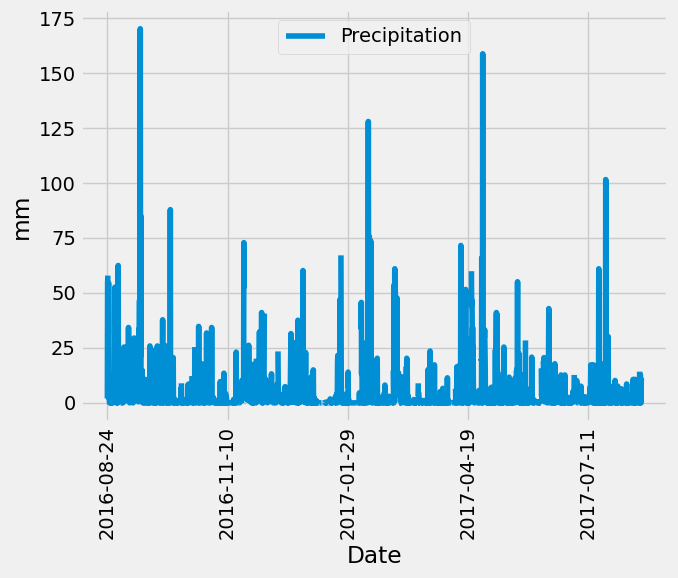

         Date  Precipitation
0  2016-08-24            2.0
1  2016-08-24           54.6
2  2016-08-24           57.9
3  2016-08-24            NaN
4  2016-08-24           31.0


In [168]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date_str = most_recent_date[0]
most_recent_date_obj = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago_date = most_recent_date_obj - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
dates = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
one_year_ago_prcp_df = pd.DataFrame(dates, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
one_year_ago_prcp_df_sorted = one_year_ago_prcp_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
one_year_ago_prcp_df_sorted.plot(x='Date', y='Precipitation', figsize=(7, 6))
plt.xlabel('Date')
plt.ylabel('mm')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print(one_year_ago_prcp_df_sorted.head())

In [85]:
# Use Pandas to calculate the summary statistics for the precipitation data
one_year_ago_prcp_df_sorted.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [105]:
# Design a query to calculate the total number of stations in the dataset
unique_stations = session.query(Station).group_by(Station.station).count()
unique_stations

9

In [96]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

active_stations
                    


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [180]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

temps = session.query(*sel).\
       filter(Measurement.station == most_active_station).all()

temps

[(12.2, 29.4, 22.03582251082252)]

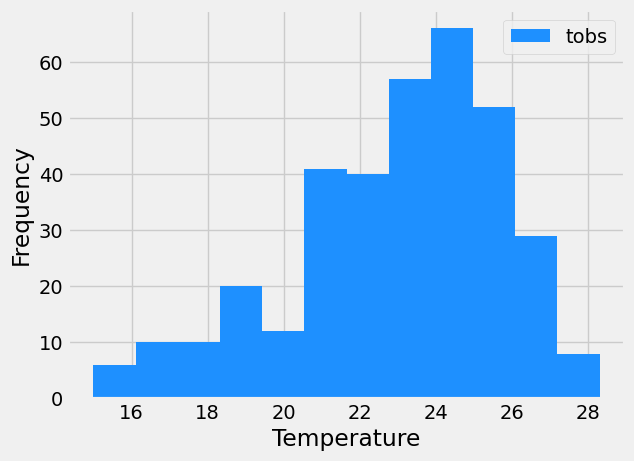

In [193]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_of_temps = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago_date).\
    filter(Measurement.station == most_active_station).all()

# Strip tuples for temp
year_temps = [x[0] for x in year_of_temps]

# Plot
plt.hist(year_temps, bins = 12, color='dodgerblue')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(["tobs"], loc="upper right")
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()
